**This notebook presents a thorough analysis of 1,000 British Airways customer reviews scraped from Skytrax. The analysis includes sentiment analysis, topic modeling, and exploratory data analysis to uncover insights about customer experiences with British Airways**

**Importing Libraries and Loading Data**

In [2]:
!pip install wordcloud


In [3]:


import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')


*setting style for plot*

In [4]:
plt.style.use('ggplot')
sns.set_palette("viridis")


*Loading the data*

In [8]:

df = pd.read_csv('BA_reviews.csv')
df = df.rename(columns={'Unnamed: 0': 'id'})


In [9]:
print("\nFirst 5 reviews:")
print(df.head())



First 5 reviews:
   id                                            reviews
0   0  Not Verified |  Check in was smooth enough. Bo...
1   1  ✅ Trip Verified | Although transferring to thi...
2   2  ✅ Trip Verified |   We are extremely grateful ...
3   3  ✅ Trip Verified |   I had an appalling experie...
4   4  Not Verified |  Good points, the cabin crew, t...


*Preprocessing the data*

In [10]:

df['verified'] = df['reviews'].apply(lambda x: 'Verified' if '✅ Trip Verified' in x else 'Not Verified')


def clean_review(text):
    text = re.sub(r'✅ Trip Verified \|', '', text)
    text = re.sub(r'Not Verified \|', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_review'] = df['reviews'].apply(clean_review)

# Extract review length
df['review_length'] = df['clean_review'].apply(len)


print("Data overview:")
print(f"Total number of reviews: {len(df)}")
verification_counts = df['verified'].value_counts()
print(f"Number of verified reviews: {verification_counts.get('Verified', 0)} ({verification_counts.get('Verified', 0)/len(df)*100:.1f}%)")
print(f"Number of non-verified reviews: {verification_counts.get('Not Verified', 0)} ({verification_counts.get('Not Verified', 0)/len(df)*100:.1f}%)")


print("\nReview length statistics:")
print(df['review_length'].describe())


print("\nDistribution of review verification:")
print(verification_counts)


Data overview:
Total number of reviews: 1000
Number of verified reviews: 740 (74.0%)
Number of non-verified reviews: 260 (26.0%)

Review length statistics:
count    1000.000000
mean      849.671000
std       605.983512
min       129.000000
25%       421.750000
50%       681.500000
75%      1082.250000
max      3474.000000
Name: review_length, dtype: float64

Distribution of review verification:
verified
Verified        740
Not Verified    260
Name: count, dtype: int64


*Visualization of Verification Status*

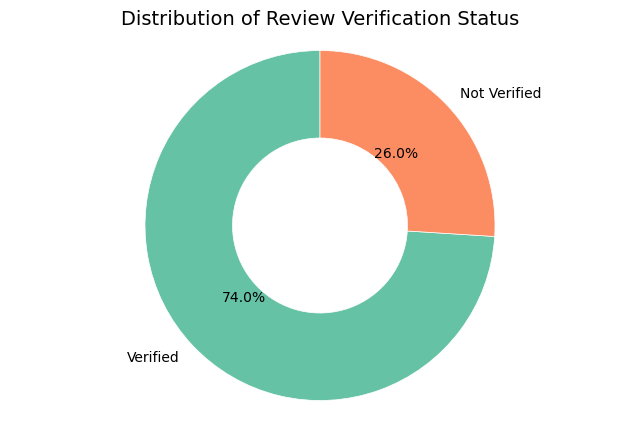

In [11]:
plt.figure(figsize=(8, 5))
plt.pie(verification_counts, labels=verification_counts.index, autopct='%1.1f%%', startangle=90,
        colors=sns.color_palette("Set2", 2), wedgeprops=dict(width=0.5, edgecolor='w'))
plt.title('Distribution of Review Verification Status', fontsize=14)
plt.axis('equal')
plt.savefig('1_verification_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


*Sentiment Analysis*

In [12]:
def analyze_sentiment(text):
    text = text.lower()
    positive_words = [
        'good', 'great', 'excellent', 'amazing', 'awesome', 'fantastic', 'wonderful', 
        'best', 'happy', 'comfortable', 'helpful', 'friendly', 'efficient', 'clean',
        'recommend', 'professional', 'impressed', 'enjoyed', 'perfect', 'smooth', 'thank',
        'pleased', 'nice', 'love', 'positive', 'exceptional', 'outstanding'
    ]
    
    negative_words = [
        'bad', 'terrible', 'poor', 'awful', 'horrible', 'worst', 'rude', 'disappoint', 
        'delay', 'cancel', 'dirty', 'uncomfortable', 'unhappy', 'complaint', 'slow',
        'unprofessional', 'never', 'problem', 'issue', 'broken', 'late', 'lost', 'sorry',
        'cramped', 'mediocre', 'chaotic', 'unfortunately', 'unacceptable', 'fail'
    ]
    
    # Count occurrences
    positive_count = sum(1 for word in positive_words if word in text)
    negative_count = sum(1 for word in negative_words if word in text)
    
    
    if positive_count > negative_count:
        return 'Positive'
    elif negative_count > positive_count:
        return 'Negative'
    else:
        # Check for strong negative words that should override
        strong_negatives = ['terrible', 'awful', 'horrible', 'worst']
        if any(word in text for word in strong_negatives):
            return 'Negative'
        # If counts are equal and no strong negatives, check length to decide
        elif len(text.split()) > 50:  # longer reviews with mixed sentiment lean negative in airlines
            return 'Negative'
        else:
            return 'Neutral'


df['sentiment'] = df['clean_review'].apply(analyze_sentiment)


*Sentiment Distribution Analysis*

Distribution of sentiment:
sentiment
Negative    663
Positive    322
Neutral      15
Name: count, dtype: int64


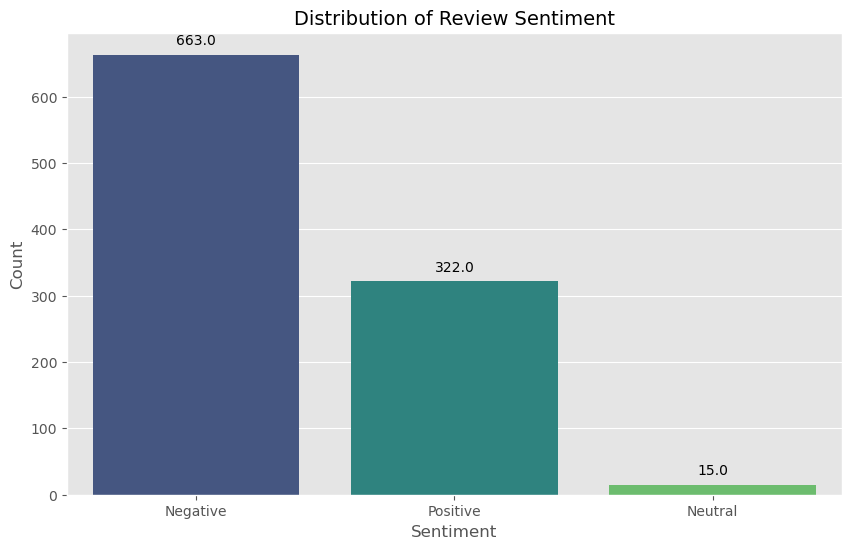

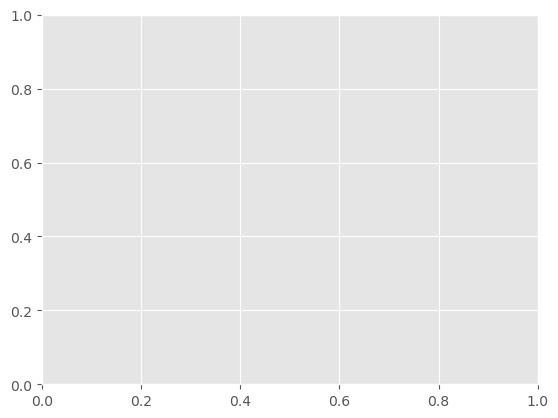

In [14]:
print("Distribution of sentiment:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribution of Review Sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.savefig('2_sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

for i, container in enumerate(plt.gca().containers):
    plt.bar_label(container, fmt='%.1f%%')

plt.savefig('3_sentiment_by_verification.png', dpi=300, bbox_inches='tight')
plt.show()


*Sentiment by Verification Status*

Sentiment by verification status:
sentiment     Negative  Neutral  Positive
verified                                 
Not Verified       186        5        69
Verified           477       10       253

Sentiment by verification status (percentage):
sentiment     Negative  Neutral  Positive
verified                                 
Not Verified      71.5      1.9      26.5
Verified          64.5      1.4      34.2


<Figure size 1000x600 with 0 Axes>

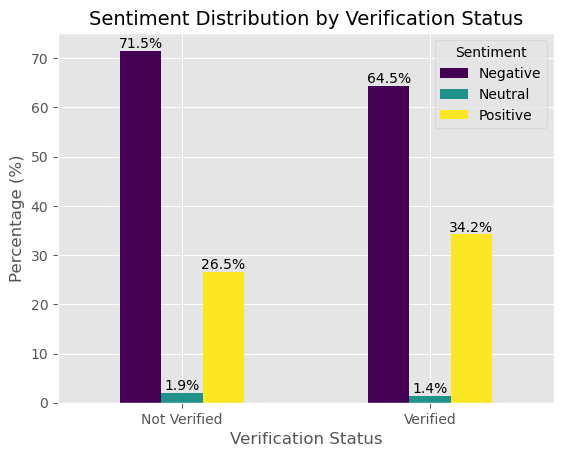

In [15]:
print("Sentiment by verification status:")
sentiment_by_verification = pd.crosstab(df['verified'], df['sentiment'])
print(sentiment_by_verification)


sentiment_by_verification_pct = sentiment_by_verification.div(sentiment_by_verification.sum(axis=1), axis=0) * 100
print("\nSentiment by verification status (percentage):")
print(sentiment_by_verification_pct.round(1))


plt.figure(figsize=(10, 6))
sentiment_by_verification_pct.plot(kind='bar', stacked=False, colormap='viridis')
plt.title('Sentiment Distribution by Verification Status', fontsize=14)
plt.xlabel('Verification Status', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Sentiment')
plt.xticks(rotation=0)


for i, container in enumerate(plt.gca().containers):
    plt.bar_label(container, fmt='%.1f%%')

plt.savefig('3_sentiment_by_verification.png', dpi=300, bbox_inches='tight')
plt.show()


*Word Cloud Analysis*

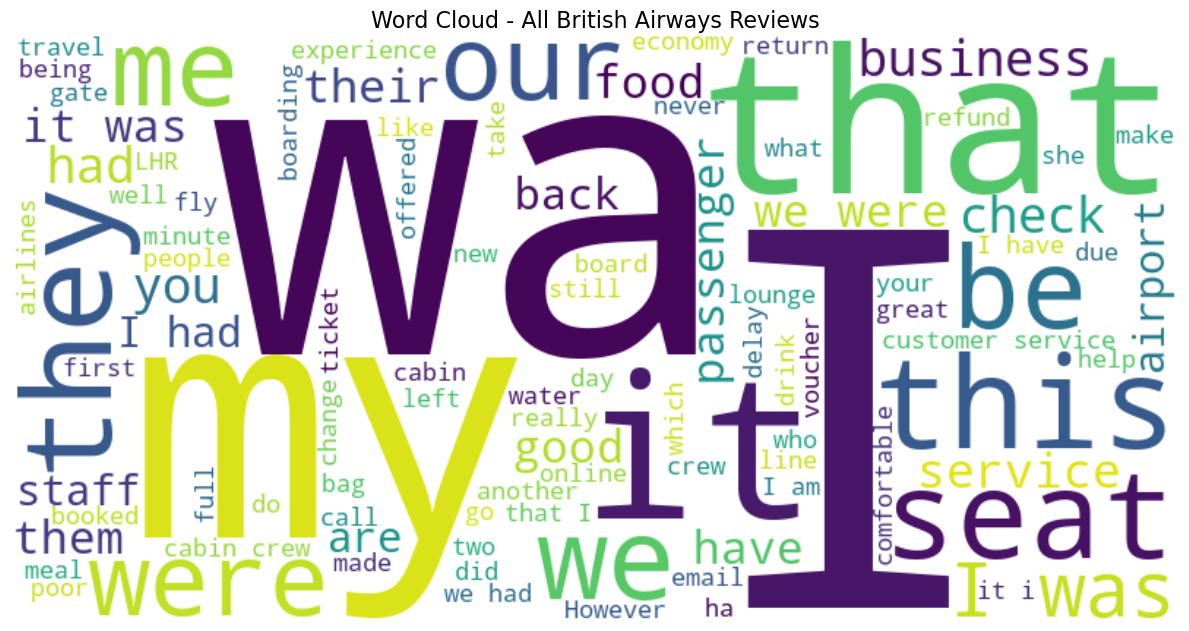

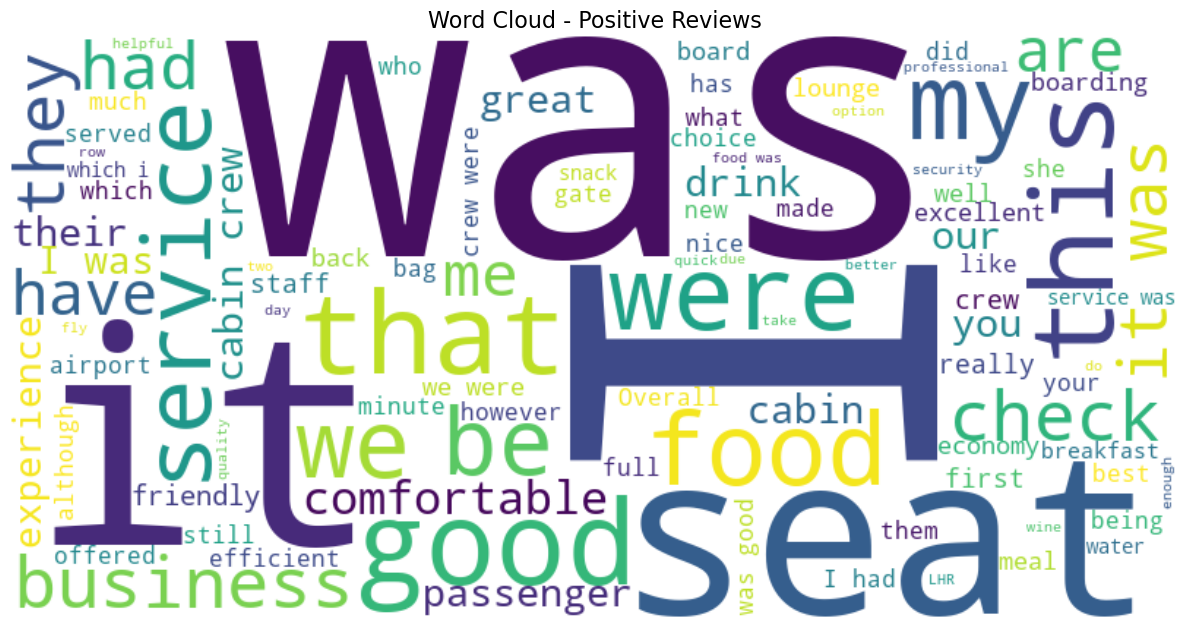

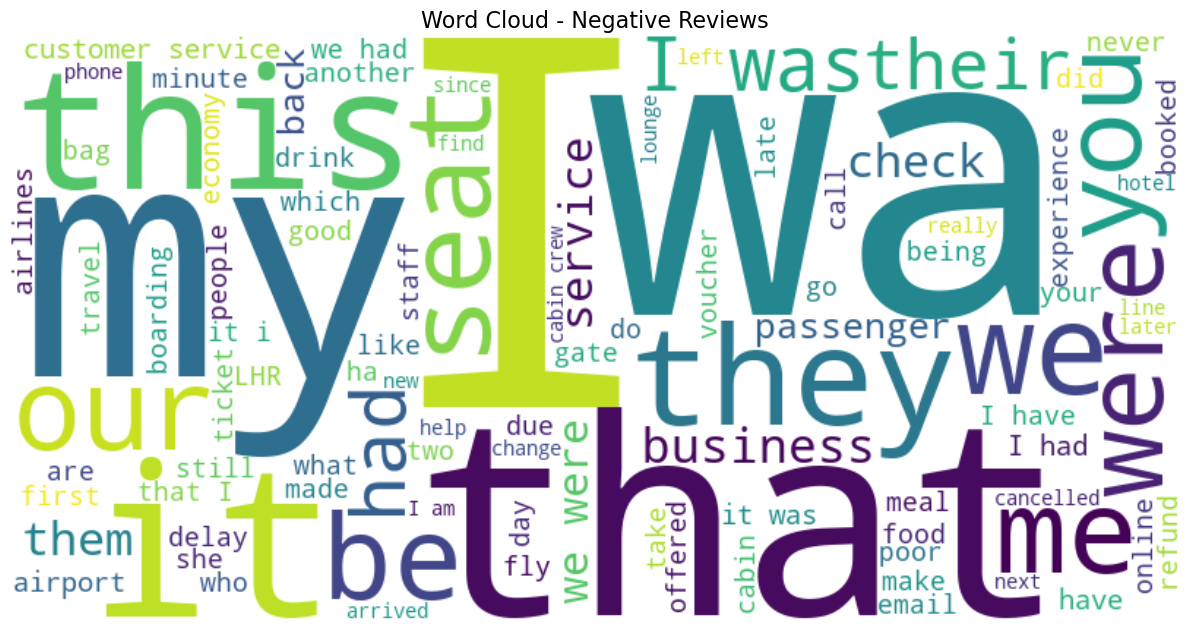

In [16]:
stop_words = [
    'british', 'airways', 'ba', 'flight', 'airline', 'plane', 'aircraft',
    'get', 'got', 'one', 'would', 'could', 'us', 'even', 'also', 'ive',
    'im', 'id', 'ill', 'cant', 'didnt', 'dont', 'doesnt', 
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
    'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
    's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'time', 'way', 'going',
    'london', 'heathrow', 'flying', 'flights', 'class', 'hour', 'hours'
]


def generate_wordcloud(text, title, filename):  
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         stopwords=stop_words,
                         max_words=100,
                         colormap='viridis',
                         contour_width=1, contour_color='steelblue').generate(text)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

all_text = ' '.join(df['clean_review'])
generate_wordcloud(all_text, 'Word Cloud - All British Airways Reviews', '4_all_reviews_wordcloud.png')


positive_text = ' '.join(df[df['sentiment'] == 'Positive']['clean_review'])
generate_wordcloud(positive_text, 'Word Cloud - Positive Reviews', '5_positive_reviews_wordcloud.png')

negative_text = ' '.join(df[df['sentiment'] == 'Negative']['clean_review'])
generate_wordcloud(negative_text, 'Word Cloud - Negative Reviews', '6_negative_reviews_wordcloud.png')


*topic modeling*

In [17]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text


df['processed_text'] = df['clean_review'].apply(preprocess_text)


print("Performing topic modeling...")
vectorizer = CountVectorizer(max_features=1000, min_df=5, stop_words=stop_words)
X = vectorizer.fit_transform(df['processed_text'])
feature_names = vectorizer.get_feature_names_out()


n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=20)
lda.fit(X)


def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append((topic_idx, top_words))
    return topics

topics = display_topics(lda, feature_names, 15)
print("Top 15 words in each topic:")
for topic_idx, words in topics:
    print(f"Topic {topic_idx+1}: {', '.join(words)}")


Performing topic modeling...
Top 15 words in each topic:
Topic 1: was, my, had, it, me, were, we, that, staff, she, crew, gate, boarding, passengers, this
Topic 2: my, was, they, that, we, me, had, have, it, our, this, is, customer, were, service
Topic 3: is, seat, business, are, seats, you, economy, was, that, this, have, they, it, premium, my
Topic 4: was, good, were, food, crew, it, is, service, cabin, club, this, lounge, which, boarding, new
Topic 5: we, were, was, have, that, they, you, this, our, had, is, it, service, are, be


*Topic interpretation*

In [18]:
topic_interpretations = []
for topic_idx, words in topics:

    if any(word in ['service', 'staff', 'crew', 'friendly', 'helpful'] for word in words[:5]):
        interpretation = "Service Quality & Crew Experience"
    elif any(word in ['food', 'meal', 'drink', 'catering'] for word in words[:5]):
        interpretation = "Food & Catering"
    elif any(word in ['seat', 'business', 'comfort', 'cabin'] for word in words[:5]):
        interpretation = "Seating & Cabin Comfort"
    elif any(word in ['delay', 'late', 'cancelled', 'cancel'] for word in words[:5]):
        interpretation = "Flight Delays & Scheduling"
    elif any(word in ['luggage', 'bag', 'baggage', 'lost'] for word in words[:5]):
        interpretation = "Baggage Handling Issues"
    else:
        interpretation = "General Customer Experience"
    
    topic_interpretations.append((topic_idx+1, interpretation))

print("Topic Interpretations:")
for topic_id, interpretation in topic_interpretations:
    print(f"Topic {topic_id}: {interpretation}")


doc_topics = lda.transform(X)
df['main_topic'] = np.argmax(doc_topics, axis=1) + 1


topic_map = {topic_id: interp for topic_id, interp in topic_interpretations}
df['topic_name'] = df['main_topic'].map(topic_map)


topic_counts = df['topic_name'].value_counts()
print("Number of reviews per topic:")
print(topic_counts)


Topic Interpretations:
Topic 1: General Customer Experience
Topic 2: General Customer Experience
Topic 3: Seating & Cabin Comfort
Topic 4: Service Quality & Crew Experience
Topic 5: General Customer Experience
Number of reviews per topic:
topic_name
General Customer Experience          627
Service Quality & Crew Experience    272
Seating & Cabin Comfort              101
Name: count, dtype: int64


*Topic distr. visuals*

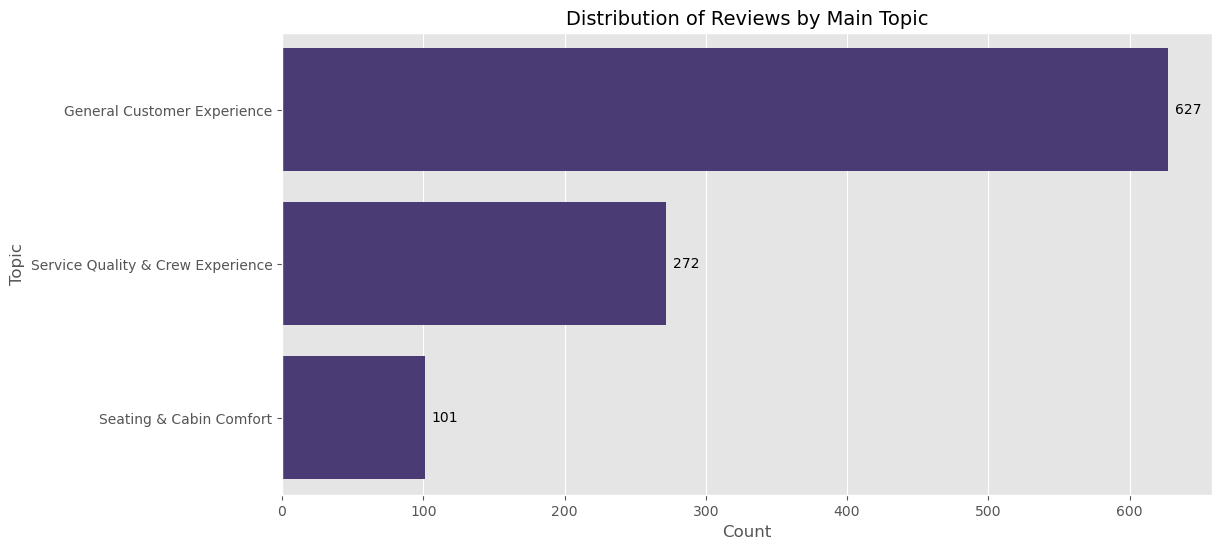

In [19]:

plt.figure(figsize=(12, 6))
ax = sns.countplot(y='topic_name', data=df, order=topic_counts.index)
plt.title('Distribution of Reviews by Main Topic', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Topic', fontsize=12)


for p in ax.patches:
    width = p.get_width()
    plt.text(width + 5, p.get_y() + p.get_height()/2, f'{width:.0f}', ha='left', va='center')

plt.savefig('8_topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


*Sentiment Distribution by Topic*

Sentiment distribution by topic:
sentiment                          Negative  Neutral  Positive
topic_name                                                    
General Customer Experience             524        9        94
Seating & Cabin Comfort                  70        2        29
Service Quality & Crew Experience        69        4       199

Sentiment distribution by topic (percentage):
sentiment                          Negative  Neutral  Positive
topic_name                                                    
General Customer Experience            83.6      1.4      15.0
Seating & Cabin Comfort                69.3      2.0      28.7
Service Quality & Crew Experience      25.4      1.5      73.2


<Figure size 1200x600 with 0 Axes>

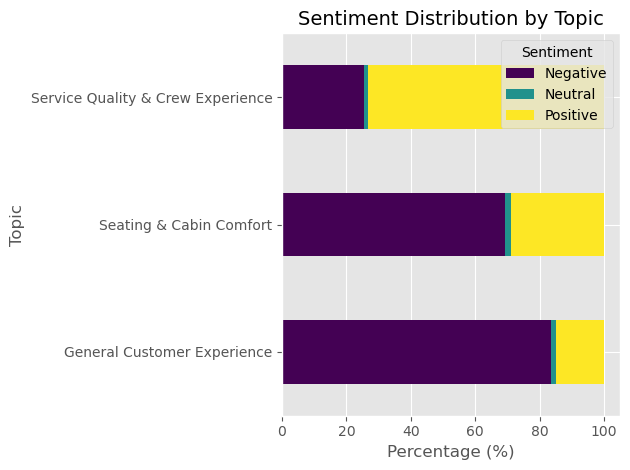

In [21]:
print("Sentiment distribution by topic:")
sentiment_by_topic = pd.crosstab(df['topic_name'], df['sentiment'])
print(sentiment_by_topic)


sentiment_by_topic_pct = sentiment_by_topic.div(sentiment_by_topic.sum(axis=1), axis=0) * 100
print("\nSentiment distribution by topic (percentage):")
print(sentiment_by_topic_pct.round(1))


plt.figure(figsize=(12, 6))
sentiment_by_topic_pct.plot(kind='barh', stacked=True, colormap='viridis')
plt.title('Sentiment Distribution by Topic', fontsize=14)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('9_sentiment_by_topic.png', dpi=300, bbox_inches='tight')
plt.show()


*Review length vs sentimental analysis*

Correlation between review length and sentiment:
Correlation coefficient: -0.134


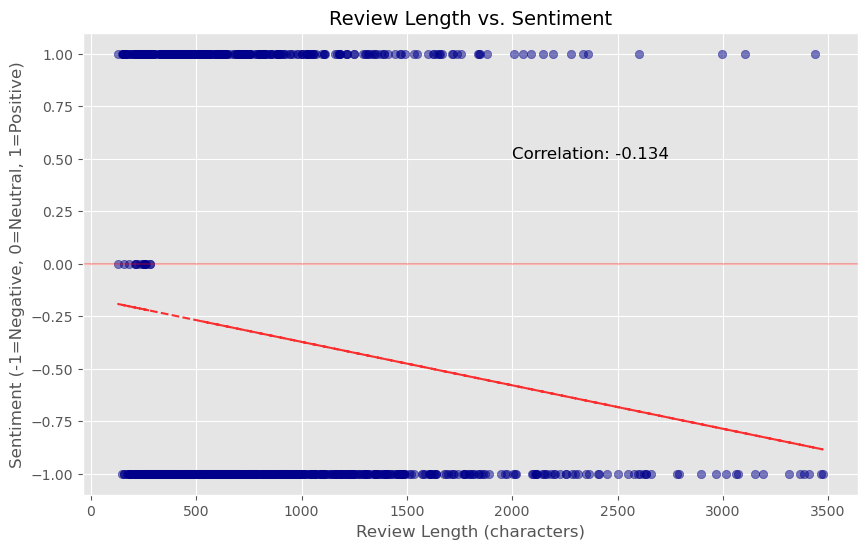

In [22]:
df['sentiment_numeric'] = df['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})


print("Correlation between review length and sentiment:")
corr = df['review_length'].corr(df['sentiment_numeric'])
print(f"Correlation coefficient: {corr:.3f}")


plt.figure(figsize=(10, 6))
plt.scatter(df['review_length'], df['sentiment_numeric'], alpha=0.5, color='darkblue')
plt.title('Review Length vs. Sentiment', fontsize=14)
plt.xlabel('Review Length (characters)', fontsize=12)
plt.ylabel('Sentiment (-1=Negative, 0=Neutral, 1=Positive)', fontsize=12)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)


z = np.polyfit(df['review_length'], df['sentiment_numeric'], 1)
p = np.poly1d(z)
plt.plot(df['review_length'], p(df['review_length']), "r--", alpha=0.8)
plt.text(2000, 0.5, f"Correlation: {corr:.3f}", fontsize=12)

plt.savefig('10_length_vs_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


*Most Frequent words analysis*

Most frequent terms in positive reviews:
was: 1153
were: 391
it: 350
is: 346
good: 307
we: 279
this: 269
my: 256
that: 244
service: 238
crew: 234
food: 214
had: 210
have: 190
cabin: 186


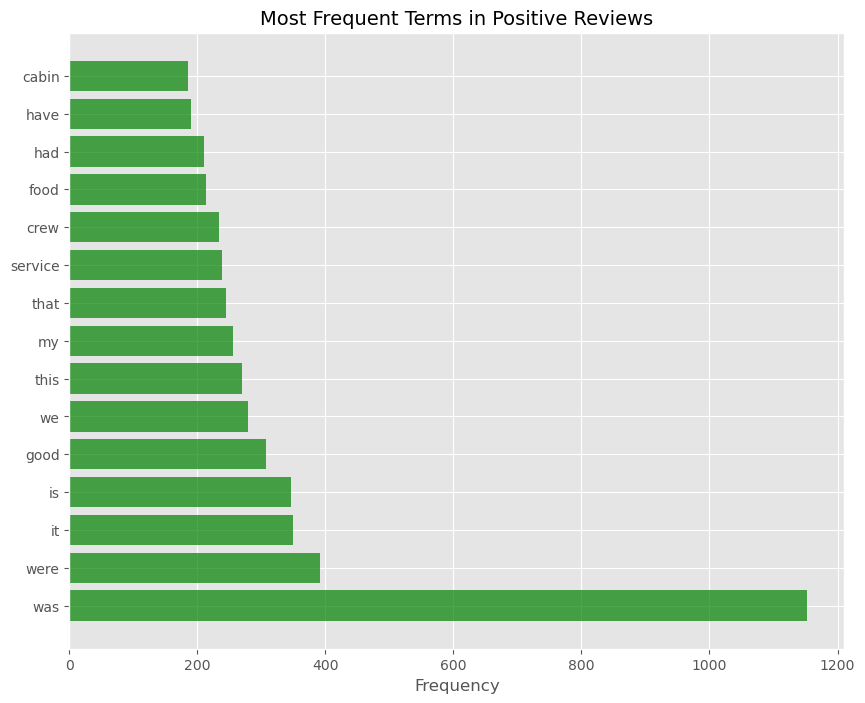

Most frequent terms in negative reviews:
was: 2105
we: 1152
my: 1122
that: 1041
they: 1030
had: 800
it: 797
is: 794
were: 738
have: 698
this: 677
me: 587
our: 516
service: 491
be: 435


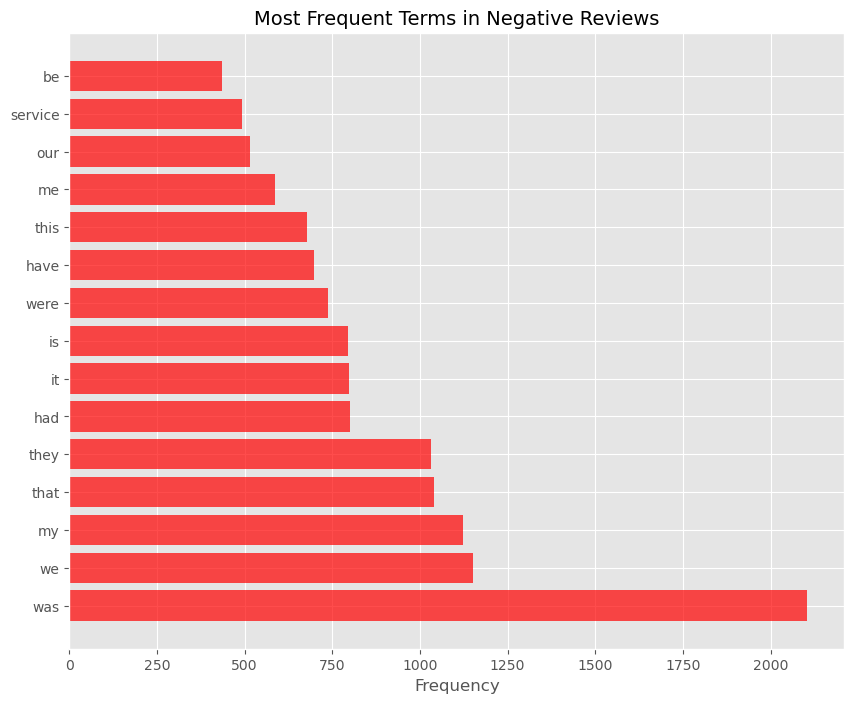

In [23]:
def get_top_n_words(corpus, n=15):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


print("Most frequent terms in positive reviews:")
positive_frequent_terms = get_top_n_words(df[df['sentiment'] == 'Positive']['processed_text'])
for word, freq in positive_frequent_terms:
    print(f"{word}: {freq}")

plt.figure(figsize=(10, 8))
words, freqs = zip(*positive_frequent_terms)
plt.barh(range(len(words)), freqs, align='center', color='green', alpha=0.7)
plt.yticks(range(len(words)), words)
plt.title('Most Frequent Terms in Positive Reviews', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.savefig('11_positive_terms.png', dpi=300, bbox_inches='tight')
plt.show()


print("Most frequent terms in negative reviews:")
negative_frequent_terms = get_top_n_words(df[df['sentiment'] == 'Negative']['processed_text'])
for word, freq in negative_frequent_terms:
    print(f"{word}: {freq}")

plt.figure(figsize=(10, 8))
words, freqs = zip(*negative_frequent_terms)
plt.barh(range(len(words)), freqs, align='center', color='red', alpha=0.7)
plt.yticks(range(len(words)), words)
plt.title('Most Frequent Terms in Negative Reviews', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.savefig('12_negative_terms.png', dpi=300, bbox_inches='tight')
plt.show()


*Topic-Sentiment Sankey Diagram*

In [25]:
try:
    import plotly.graph_objects as go
    import plotly.io as pio
    
    # Prepare data for Sankey diagram
    topic_sent_counts = pd.crosstab(df['topic_name'], df['sentiment'])
    
    # Create lists for sources, targets, values, and labels
    source = []
    target = []
    value = []

    topics = topic_sent_counts.index.tolist()
    sentiments = topic_sent_counts.columns.tolist()
    

    labels = topics + sentiments
    

    topic_idx = {topic: i for i, topic in enumerate(topics)}
    sent_idx = {sent: i + len(topics) for i, sent in enumerate(sentiments)}
    

    for topic in topics:
        for sent in sentiments:
            source.append(topic_idx[topic])
            target.append(sent_idx[sent])
            value.append(topic_sent_counts.loc[topic, sent])
    

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=["rgba(31, 119, 180, 0.8)"] * len(topics) + 
                  ["rgba(44, 160, 44, 0.8)" if s == "Positive" else 
                   "rgba(214, 39, 40, 0.8)" if s == "Negative" else 
                   "rgba(148, 103, 189, 0.8)" for s in sentiments]
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color="rgba(100, 100, 100, 0.2)"
        )
    )])
    
    fig.update_layout(
        title_text="Flow from Topics to Sentiment",
        font_size=12
    )
    

    pio.write_image(fig, '13_topic_sentiment_sankey.png', scale=2)
    print("Sankey diagram created successfully.")
    
except Exception as e:
    print(f"Could not create Sankey diagram: {e}")


Could not create Sankey diagram: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



*Summary*

In [27]:
print("Summary Statistics:")
print(f"Total number of reviews: {len(df)}")
print(f"Verified reviews: {len(df[df['verified'] == 'Verified'])} ({len(df[df['verified'] == 'Verified'])/len(df)*100:.1f}%)")
print(f"Average review length: {df['review_length'].mean():.1f} characters")
print(f"Positive reviews: {len(df[df['sentiment'] == 'Positive'])} ({len(df[df['sentiment'] == 'Positive'])/len(df)*100:.1f}%)")
print(f"Negative reviews: {len(df[df['sentiment'] == 'Negative'])} ({len(df[df['sentiment'] == 'Negative'])/len(df)*100:.1f}%)")
if 'Neutral' in df['sentiment'].unique():
    print(f"Neutral reviews: {len(df[df['sentiment'] == 'Neutral'])} ({len(df[df['sentiment'] == 'Neutral'])/len(df)*100:.1f}%)")


df[['id', 'clean_review', 'verified', 'review_length', 'sentiment', 'topic_name']].to_csv('ba_reviews_analyzed.csv', index=False)
print("Analysis complete results saved to 'ba_reviews_analyzed.csv'")


Summary Statistics:
Total number of reviews: 1000
Verified reviews: 740 (74.0%)
Average review length: 849.7 characters
Positive reviews: 322 (32.2%)
Negative reviews: 663 (66.3%)
Neutral reviews: 15 (1.5%)
Analysis complete results saved to 'ba_reviews_analyzed.csv'


In [ ]:
*Conclusion
This analysis of British Airways customer reviews has revealed valuable insights into customer experiences and sentiment. The predominantly negative sentiment (66.3%) indicates significant challenges for British Airways, but the analysis also highlights areas of strength, particularly in service quality and crew experience.
The clear division between topics—with Service Quality receiving mostly positive feedback and General Customer Experience receiving mostly negative feedback—provides a roadmap for improvement efforts. British Airways should maintain their strong service culture while addressing operational issues that drive negative sentiment.
By implementing the recommendations outlined in this report, British Airways can leverage their strengths while systematically addressing areas of weakness to improve overall customer satisfaction and loyalty.
